# Aufgabe 3

## 3.1 Fossile Erzeugung

In [27]:
import pyomo.environ as pyo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

T = 24
timesteps = np.arange(T)

c_CO2 = 7 # EUR/tCO2

# Marginal costs der thermischen Kraftwerke berechnen
thermalPlant = ['Kohle', 'GuD', 'Gasturbine']
power = {'Kohle': 600,
         'GuD': 400,
         'Gasturbine': 300} # MW
efficiency = {'Kohle': 0.41,
         'GuD': 0.58,
         'Gasturbine': 0.4} 
fuel_price = {'Kohle': 10,
         'GuD': 25,
         'Gasturbine': 25} # EUR/MWhprim
emission_factor = {'Kohle': 0.35,
         'GuD': 0.2,
         'Gasturbine': 0.2} # tCO2/MWhprim
MC = {} # marginal costs in EUR/MWh
emissions = {} # emissions in tCO2/MWh
for n in thermalPlant:
    MC[n] = (fuel_price[n] + emission_factor[n] * c_CO2) / efficiency[n]
    emissions[n] = emission_factor[n] / efficiency[n]
    
# Daten laden
df = pd.read_excel('Last_PV_Wind.xlsx')
load = df['Last Sommer [MW]'] # hier nach Gruppennummer Sommer/Winter eingeben
wind = df['Wind 300 MW']
PV_100 = df['PV 100 MW Sommer']

# Speicher
Q_turb = 200 # MW
Q_pump = 200 # MW
SOC_max = 600 # MWh
SOCstart = 0 # MWh
eta_turb = 0.9 
eta_pump = 0.9 


In [46]:
load.loc[0]

600

In [44]:
# Pyomo Modell aufstellen

model = pyo.ConcreteModel()

model.x = pyo.Var(thermalPlant, timesteps, within=pyo.NonNegativeReals)

# Zielfunktion
def zielfunktion(model):
    return sum(model.x[n, t] * MC[n] for n in thermalPlant for t in timesteps)
               
model.obj = pyo.Objective(rule=zielfunktion, 
                          sense=pyo.minimize)

def power_constraint_rule(model, n, t):    
   return model.x[n,t] <= power[n]
model.power_con = pyo.Constraint(thermalPlant, 
                             timesteps, 
                             rule = power_constraint_rule)

def load_constraint_rule(model, t):    
   return sum(model.x[n,t] for n in thermalPlant) == load.loc[t]
model.load_con = pyo.Constraint(timesteps, 
                            rule = load_constraint_rule)

opt = pyo.SolverFactory('gurobi')
opt_success = opt.solve(model)

model.display()

# get values of optimization variables
PowerThermal = pd.DataFrame(index = timesteps, columns = thermalPlant)
for t in timesteps:
    for n in thermalPlant:
        PowerThermal.loc[t, n] = model.x[n,t].value



Model unknown

  Variables:
    x : Size=72, Index=x_index
        Key                : Lower : Value : Upper : Fixed : Stale : Domain
         ('Gasturbine', 0) :     0 :   0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 1) :     0 :   0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 2) :     0 :   0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 3) :     0 :   0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 4) :     0 :   0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 5) :     0 :   0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 6) :     0 :   0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 7) :     0 :   0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 8) :     0 :   0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 9) :     0 :   0.0 :  None : False : False : NonNegativeReals
     

b) Graphische Darstellung:

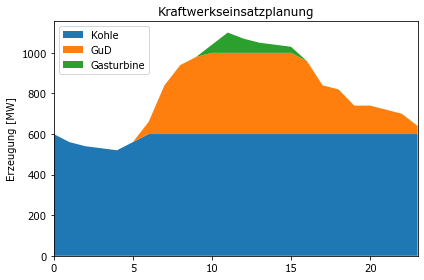

Die Gesamtkosten der Stromversorgung belaufen sich auf: 667814.61 €
Die Gesamtemissionen der Stromerzeugung für diesen Tag betragen 13858.4 t CO2


In [38]:
# plo
fig, ax = plt.subplots()
ax.stackplot(timesteps, 
             PowerThermal.to_numpy(dtype = float).transpose(), 
             labels=thermalPlant)
ax.set_title('Kraftwerkseinsatzplanung')
ax.legend(loc='upper left')
ax.set_ylabel('Erzeugung [MW]')
ax.set_xlim(xmin=timesteps[0], xmax=timesteps[-1])
fig.tight_layout()
plt.show()
print("Die Gesamtkosten der Stromversorgung belaufen sich auf: " + str(round(model.obj(), 2)) + " €")
# Emisionen:
GesamtEmissionen = sum(emissions[n] * model.x[n, t].value for t in timesteps for n in thermalPlant)
print("Die Gesamtemissionen der Stromerzeugung für diesen Tag betragen "+str(round(GesamtEmissionen,2))+" t CO2")

d) Der stündliche Strompreis unter optimalem Wetbewerb ergibt sich aus den Grenzkosten:


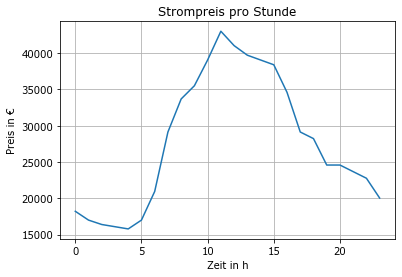

In [12]:
strompreis_pro_stunde = []
for i in timesteps:
    preis = sum(PowerThermal.loc[i, n] * MC[n] for n in thermalPlant)
    strompreis_pro_stunde.append(preis)

# plot
plt.plot(timesteps, strompreis_pro_stunde)
plt.title("Strompreis pro Stunde")
plt.ylabel("Preis in €")
plt.xlabel("Zeit in h")
plt.grid()

## 3.2 Erneuerbare Erzeugung

a)

In [40]:
# Erneurbare müssen abgenommen werden: load - wind - PV 100 
load_new = load - wind - PV_100 

model = pyo.ConcreteModel()

model.x = pyo.Var(thermalPlant, timesteps, within=pyo.NonNegativeReals)
#model.schattenvar = pyo.Suffix()

# Zielfunktion
def zielfunktion(model):
    return sum(model.x[n, t] * MC[n] for n in thermalPlant for t in timesteps)
               
model.obj = pyo.Objective(rule=zielfunktion, 
                          sense=pyo.minimize)

def power_constraint_rule(model, n, t):    
   return model.x[n,t] <= power[n]
model.power_con = pyo.Constraint(thermalPlant, 
                             timesteps, 
                             rule = power_constraint_rule)

def load_constraint_rule(model, t):    
   return sum(model.x[n,t] for n in thermalPlant) == load_new.loc[t]
model.load_con = pyo.Constraint(timesteps, 
                            rule = load_constraint_rule)

opt = pyo.SolverFactory('gurobi')
opt_success = opt.solve(model, report_timing=True)

model.display()

        0.01 seconds required to write file
        0.01 seconds required for presolve
        0.12 seconds required for solver
        0.00 seconds required to read logfile 
        0.01 seconds required to read solution file 
        0.02 seconds required for postsolve
Model unknown

  Variables:
    x : Size=72, Index=x_index
        Key                : Lower : Value              : Upper : Fixed : Stale : Domain
         ('Gasturbine', 0) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 1) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 2) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 3) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 4) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 5) :     0 :                0.0 :  None : False : False : Non

b)

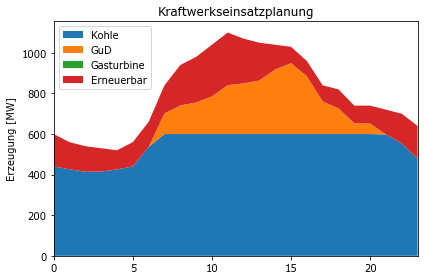

Die Gesamtkosten der Stromversorgung belaufen sich auf: 520704.52 €
Die Gesamtemissionen der Stromerzeugung für diesen Tag betragen 12132.18 t CO2


In [16]:
# get values of optimization variables
PowerThermalandRenewable = pd.DataFrame(index = timesteps, 
                                        columns = ['Kohle', 
                                                   'GuD', 
                                                   'Gasturbine', 
                                                   'Erneuerbar']
                                        )
for t in timesteps:
    PowerThermalandRenewable.loc[t, 'Erneuerbar'] = wind[t] + PV_100[t] 
    for n in thermalPlant:
        PowerThermalandRenewable.loc[t, n] = model.x[n,t].value

fig, ax = plt.subplots()
ax.stackplot(timesteps, 
              PowerThermalandRenewable.to_numpy(dtype = float).transpose(), 
              labels=['Kohle', 'GuD', 'Gasturbine', 'Erneuerbar'])
ax.set_title('Kraftwerkseinsatzplanung')
ax.legend(loc='upper left')
ax.set_ylabel('Erzeugung [MW]')
ax.set_xlim(xmin=timesteps[0], xmax=timesteps[-1])
fig.tight_layout()
plt.show()
print("Die Gesamtkosten der Stromversorgung belaufen sich auf: " + str(round(model.obj(), 2)) + " €")
# Emisionen:
GesamtEmissionen = sum(emissions[n] * model.x[n, t].value for t in timesteps for n in thermalPlant)
print("Die Gesamtemissionen der Stromerzeugung für diesen Tag betragen "+str(round(GesamtEmissionen,2))+" t CO2")

c)

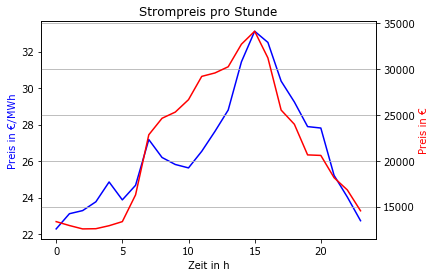

In [17]:
strompreis_pro_stunde = []
for i in timesteps:
    preis = sum(PowerThermalandRenewable.loc[i, n] * MC[n] for n in thermalPlant)
    strompreis_pro_stunde.append(preis)

# plot
fig = plt.figure()
ax = plt.gca()
ax2 = ax.twinx()
ax.plot(timesteps, strompreis_pro_stunde/load, color="blue")
ax.set_title("Strompreis pro Stunde")
ax.set_ylabel("Preis in €/MWh")
ax2.plot(timesteps, strompreis_pro_stunde, color="red")
ax2.set_ylabel("Preis in €")
ax.set_xlabel("Zeit in h")
ax.yaxis.label.set_color('blue')
ax2.yaxis.label.set_color('red')
plt.grid()

## 3.3 Speicher

In Aufgabe 3.3 sind wieder der kostenminimale Kraftwerkseinsatz sowie die Gesamtkosten und THG-Emissionen inklusive erneuerbarer Erzeugung und als neuen Aspekt inklusive der Speicher zu ermitteln und mathematisch darzustellen. Weiters sind die Emissionen im Vergleich zum Fall ohne Speicher sowie ohne EE zu analaysieren und die stündlichen Strompreise darzustellen. 

3.3 a)
Es werden der kostenminimale Kraftwerkseinsatz und die Gesamtkosten und THG-Emissionen inklusive erneuerbarer Erzeugung und Speicher dargestellt.
Wir haben angenommen, dass der Speicher am Anfang sowie am Ende der Periode leer ist.
Der kostenminimale Kraftwerkseinsatz wird unterhalb dargestellt.

In [82]:
# Speicher inkludiert, Erneuerbare müssen abgenommen werden: load - wind - PV 100 
load_storage = load - wind - PV_100 

model = pyo.ConcreteModel()

model.x = pyo.Var(thermalPlant, timesteps, within=pyo.NonNegativeReals)
model.q_turb = pyo.Var(timesteps, bounds = (0, Q_turb))
model.q_pump = pyo.Var(timesteps, bounds = (0, Q_pump))
model.SOC = pyo.Var(timesteps, bounds = (0, SOC_max))

#model.storage = pyo.Var(storage, timesteps)
#model.schattenvar = pyo.Suffix()

# Zielfunktion
def zielfunktion(model):
    return sum(model.x[n, t] * MC[n] for n in thermalPlant for t in timesteps)
               
model.obj = pyo.Objective(rule=zielfunktion, 
                          sense=pyo.minimize)

def power_constraint_rule(model, n, t):    
   return model.x[n,t] <= power[n]
model.power_con = pyo.Constraint(thermalPlant, 
                             timesteps, 
                             rule = power_constraint_rule)

def load_constraint_rule(model, t):    
   return sum(model.x[n,t] for n in thermalPlant) == (load_new.loc[t] + model.q_pump[t] - model.q_turb[t])
model.load_con = pyo.Constraint(timesteps, 
                            rule = load_constraint_rule)

# q_turb
def qturb_constraint_rule(model, t):  
   return model.q_turb[t] <= model.SOC[t-1]

model.qturb_init_con = pyo.Constraint(
        expr = (model.q_turb[0] <= SOCstart))

model.qturb_con = pyo.Constraint(timesteps[1:], rule = qturb_constraint_rule)

# SOC
def SOC_constraint_rule(model, t):  
   return (model.SOC[t-1] 
           + model.q_pump[t]*eta_pump 
           - model.q_turb[t]/eta_turb 
           - model.SOC[t] == 0)

# Storage equation
model.SOC_init_con = pyo.Constraint(
        expr = (SOCstart 
                + model.q_pump[0]*eta_pump 
                - model.q_turb[0]/eta_turb 
                - model.SOC[0] == 0))

model.SOC_con = pyo.Constraint(timesteps[1:], 
                           rule = SOC_constraint_rule)

model.SOC_end_con = pyo.Constraint(
        expr = (model.SOC[T-1] == SOCstart))                           
#def pump_constraint_rule(model, t):    
#   return model.q_pump[t] <= Q_pump
#model.pump_con = pyo.Constraint(timesteps,
#                            rule = pump_constraint_rule)

opt = pyo.SolverFactory('gurobi')
opt_success = opt.solve(model, report_timing=True)

model.display()


        0.01 seconds required to write file
        0.02 seconds required for presolve
        0.11 seconds required for solver
        0.00 seconds required to read logfile 
        0.00 seconds required to read solution file 
        0.00 seconds required for postsolve
Model unknown

  Variables:
    x : Size=72, Index=x_index
        Key                : Lower : Value              : Upper : Fixed : Stale : Domain
         ('Gasturbine', 0) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 1) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 2) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 3) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 4) :     0 :                0.0 :  None : False : False : NonNegativeReals
         ('Gasturbine', 5) :     0 :                0.0 :  None : False : False : Non

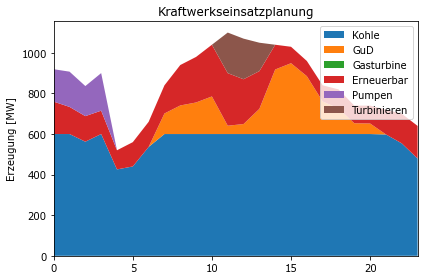

Die Gesamtkosten der Stromversorgung belaufen sich auf: 516369.12 €
Die Gesamtemissionen der Stromerzeugung für diesen Tag betragen 12515.08 t CO2


In [90]:
# get values of optimization variables
PowerThermalandRenewableandStorage = pd.DataFrame(index = timesteps, 
                                        columns = ['Kohle', 
                                                   'GuD', 
                                                   'Gasturbine', 
                                                   'Erneuerbar',
                                                   'Pumpen',
                                                   'Turbinieren']
                                        )
for t in timesteps:
    PowerThermalandRenewableandStorage.loc[t, 'Erneuerbar'] = wind[t] + PV_100[t] 
    PowerThermalandRenewableandStorage.loc[t, 'Pumpen'] = model.q_pump[t].value
    PowerThermalandRenewableandStorage.loc[t, 'Turbinieren'] = model.q_turb[t].value
    for n in thermalPlant:
        PowerThermalandRenewableandStorage.loc[t, n] = model.x[n,t].value

fig, ax = plt.subplots()
ax.stackplot(timesteps, 
              PowerThermalandRenewableandStorage.to_numpy(dtype = float).transpose(), 
              labels=['Kohle', 'GuD', 'Gasturbine', 'Erneuerbar', 'Pumpen', 'Turbinieren'])
ax.set_title('Kraftwerkseinsatzplanung')
ax.legend(loc='upper right')
ax.set_ylabel('Erzeugung [MW]')
ax.set_xlim(xmin=timesteps[0], xmax=timesteps[-1])
fig.tight_layout()
plt.show()

print(f"Die Gesamtkosten der Stromversorgung belaufen sich auf: {model.obj():.2f} €")
# Emisionen:
GesamtEmissionen = sum(emissions[n] * model.x[n, t].value for t in timesteps for n in thermalPlant)
print(f"Die Gesamtemissionen der Stromerzeugung für diesen Tag betragen {GesamtEmissionen:.2f} t CO2")

3.3 b) Das mathematische Modell inkl. Speicher sieht folgendermaßen aus: 

**Zielfunktion**

$minimize \ C = \sum \limits _{t=1} ^{24} P_{KKt}\ MC_{KK} + P_{GuDt} \ MC_{GuD} + P_{Gt} \ MC_{G}$

**Nebenbedingungen**

$ Last_{t} = P_{KKt} + P_{GuDt} + P_{Gt} + P_{Windt} + P_{PVt} - q_{pumpt} + q_{turbt}  \ für \ t = 0,1,...,23. $  

$ 0 \le P_{KKt} \le 600,$  
$ 0 \le P_{GuDt} \le 400,$  
$ 0 \le P_{Gt} \le 300,$  
$ 0 \le q \le 200,$   
$ 0 \le SOC_{t} \le 600 \ für  \ t = 0,1,...,23.$   

$ SOC_{0} = 0 \ and \ SOC_{24} = 0 $  

$ Q_{turbt} \le SOC_{t-1} \ für  \ t = 1,2,...,23.$ 

$ SOC_{t} = SOC_{t-1} + q_{pumpt} * \eta_{pump} - q_{turbt}/\eta_{turb} \ für  \ t = 1,2,...,23.$ 


Variablen:  
KK = Kohle  
GuD = Gas und Dampf  
G = Gas   
P = Leistung  
MC = kurzfristige Grenzkosten  
L = Last  
q = Leistung pumpen/turbinieren  
SOC = Speicherstand (state of charge)  
$\eta$ = Effizienz




3.3 c) Durch den Speicherbetrieb erhöhen sich die Gesamtemissionen. Da in unserem Modell lediglich hinischtlich der Kosten optimiert wird, wird die Stromerzeugung des Pumpspeicherkraftwerks in Stunden verlegt in denen sonst mit emissionsärmere GuD Kraftwerke erzeugt werden würden. Die Turbinierung erfolgt in Stunden in denen mit Kohle produziert wird.  
In der Realität müsste die Emissionskomponente im Modell berücksichtigt werden, da es nicht zielführend ist höhere Kohlekapazitäten in Anspruch zu nehmen. 

3.3 d) Die Änderung der stündlichen Strompreise ist in untenstehender Grafik dargestellt. 

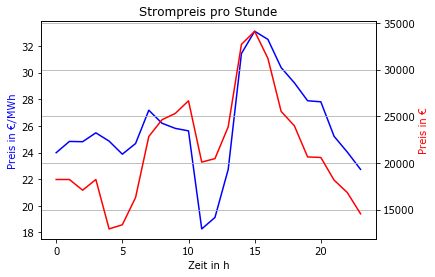

In [107]:
strompreis_pro_stunde = []
pump_last = []
for i in timesteps:
    preis = sum(PowerThermalandRenewableandStorage.loc[i, n] * MC[n] for n in thermalPlant)
    strompreis_pro_stunde.append(preis)
    pump_last.append(model.q_pump[i].value)

# plot
fig = plt.figure()
ax = plt.gca()
ax2 = ax.twinx()
ax.plot(timesteps, strompreis_pro_stunde/(load + pump_last), color="blue")
ax.set_title("Strompreis pro Stunde")
ax.set_ylabel("Preis in €/MWh")
ax2.plot(timesteps, strompreis_pro_stunde, color="red")
ax2.set_ylabel("Preis in €")
ax.set_xlabel("Zeit in h")
ax.yaxis.label.set_color('blue')
ax2.yaxis.label.set_color('red')
plt.grid()

3.3 e)

| Modell                | Gesamtkosten (€) | Gesamtemissionen (t CO2) |
|-----------------------|------------------|--------------------------|
| Fossile Erzeugung     | 667814.61        | 13858.4                  |
| Erneuerbare Erzeugung | 520704.52        | 12132.18                 |
| Inklusive Speicher    | 516369.12        | 12515.08                 |

Es ist zu sehen, dass die Gesamtkosten bei fossiler Erzeugung am höchsten sind. Durch die Integration von EE und Speicher können die Kosten gesenkt werden.
Hinsichtlich der Emissionen ist zu sehen, dass diese durch die Integration der EE sinken jedoch durch den Einsatz des Speichers aus den in 3.3 c genannten Gründen wieder steigen. 